# The Movie Director's Office

## Introduction to the tool

We will create new classes for the Movie Director's Office. Each class encapsulates the functions that could be assigned to different employees in the office. The classes are:

- `MDO_Researcher`: Core member of the Movie Director Office, the researcher will try to collect and clean the data. The data will be used by the other members for exploration, visualization, and prediction.

- `MDO_Statistician`: First employee of the Movie Director Office, the statistician is in charge of the data exploration. He can provide summary statistics, correlation analysis and ANOVA tests.

- `MDO_Agent`: Second employee of the Movie Director Office, the agent knows his way around the movie industry. He can provide insights into directors, actors and their relationships.

- `MDO_Forecaster`: Third employee of the Movie Director Office, the forecaster is in charge of predicting the success of a movie. He can train and compare different models to predict the box office revenue of a movie.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests
import geopandas as gpd
import folium
import pickle
import networkx as nx
import datetime

from scipy.stats import f_oneway, pearsonr

# Regression models
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.dummy import DummyRegressor

# Helpers
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

from sklearn.model_selection import cross_validate, cross_val_predict

pd.options.display.max_columns = None

## The Researcher

In [17]:
class MDO_Researcher():
    """Core member of the Movie Director Office, the researcher will try to collect and clean the data.
    The data will be used by the other members for exploration, visualization, and prediction.

    Attributes
    ----------
    pre : pd.DataFrame
        Pre-release dataset
    after : pd.DataFrame
        After-release dataset
    full : pd.DataFrame
        Merged dataset
    pred_columns : list
        List of predictors
    success_columns : list
        List of success metrics
    
    Initiation
    ----------

    from_directory(directory:str) -> None
        Create a MDO_Researcher object from a directory containing the pre and after release datasets.
    
    from_enriched(
        path:str="../data/enriched_data.csv",
        successes:list=[
            "gross", "num_voted_users", "num_user_for_reviews", "imdb_score", "movie_facebook_likes",
            "profit", "num_critic_for_reviews"],
            **class_arg) -> None
        Initiate the dataset from a csv file with enriched data.

        
    Methods
    -------

    prepare_data(verbose:bool=False) -> None
        Prepare the data by dropping duplicates and merging the two datasets.

    split_genres(top:int=10, verbose:bool=False) -> None
        Split the top genres into individual columns and add one for all other genres.
    
    enrich_with_country(
        path:str="../data/countries_shape/ne_110m_admin_0_countries.shp",
        country_replacement:dict={"United States of America": "USA", "United Kingdom": "UK", "Czechia": "Czech Republic"},
        columns:list=["NAME", "POP_EST", "GDP_MD"], replace:bool=True) -> None
        Enrich the data with information about the country of the movie.
    
    enrich_with_actors(
        path:str="../data/actors.pickle",
        centralities:list=["degree", "closeness", "betweenness"], replace:bool=True) -> None
        Enrich the data with information about the network of actors across movies.
    
    enrich_all(
        save:bool=False, path:str="../data/enriched_dataset.csv",
        country:bool=True, actors:bool=True, country_par:dict={}, actors_par:dict={}) -> None
        Enrich the data with all the available methods. It includes addition of profit as a success metric.
    """

    def __init__(
        self,
        pre:str = "../data/pre_release.csv",
        after:str = "../data/after_release.csv") -> None:

        self.pre = pd.read_csv(pre)
        self.after = pd.read_csv(after)
        self.full = None
        self.pred_columns = None
        self.success_columns = None

    ### Automatic generation:

    @classmethod
    def from_directory(cls, directory:str, drop_na:bool=True) -> None:
        """Create a MovieCFO object from a directory containing the pre and after release datasets.

        Parameters
        ----------
        directory : str
            Path to the directory containing the two datasets
        """
        for file in os.listdir(directory):
            if "pre" in file and file.endswith(".csv"):
                pre = os.path.join(directory, file)
            elif "after" in file and file.endswith(".csv"):
                after = os.path.join(directory, file)
        obj = cls(pre, after)
        obj.prepare_data()
        obj.full.dropna(inplace=drop_na)
        return obj
    
    ### Initiate class with enriched data

    @classmethod
    def from_enriched(
        cls,
        path:str = "../data/enriched_data.csv",
        successes = [
            "gross", "num_voted_users", "num_user_for_reviews",
            "imdb_score", "movie_facebook_likes", "profit", "num_critic_for_reviews"],
        drop_na:bool = True,
        **class_arg) -> None:
        """Initiate the dataset from a csv file with enriched data.

        Parameters
        ----------
        path : str, optional
            Path to the enriched dataset, by default "../data/enriched_data.csv"
        successes : list, optional
            Columns which are observed after the movie release.
        drop_na : bool, optional
            Drop missing values, by default True
        class_arg : dict
            Arguments for the class initiation (pre and after datasets)
        """
        obj = cls(**class_arg)
        obj.full = pd.read_csv(path)
        obj.success_columns = successes
        obj.pred_columns = [col for col in obj.full.columns if col not in obj.success_columns]
        if drop_na:
            obj.full.dropna(inplace=True)
        return obj

    #># Method 1:

    def prepare_data(self, verbose:bool=False) -> None:
        """Prepare the data by dropping duplicates and merging the two datasets.

        Parameters
        ----------
        verbose : bool, optional
            Display execution details, by default False
        """
        # ---
        if verbose:
            print("".join([
                f"Pre-release: {self.pre.shape[0]} rows with {self.pre.movie_title.unique().shape[0]}",
                " unique movies\n",
                f"After-release: {self.after.shape[0]} rows with {self.after.movie_title.unique().shape[0]}",
                " unique movies\n"
            ]))

        # Dropping duplicates before merging
        self.pre.drop_duplicates(subset=["movie_title"], inplace=True)
        self.after.drop_duplicates(subset=["movie_title"], inplace=True)

        # Merging the two datasets
        self.full = pd.merge(self.pre, self.after, on="movie_title", how="inner", suffixes=("_pred", "_success"))
        self.pred_columns = [col for col in self.pre.columns]
        self.success_columns = [col for col in self.after.columns if col != "movie_title"]
        
        # ---
        if verbose:
            print(f"Full dataset: {self.full.shape[0]} unique movies.")

    #># Method 2:

    def split_genres(self, top:int=10, verbose:bool=False) -> None:
        """Split the genres into individual columns.

        Parameters
        ----------
        top : int, optional
            Number of top genres to keep, by default 10
        verbose : bool, optional
            Display execution details, by default False
        """

        # Get the top genres and the rest 
        self.full["genres"] = self.full["genres"].str.split("|")
        genre_count = self.full["genres"].explode().value_counts()
        top_genres = genre_count.head(top).index.tolist()
        other_genres = genre_count.index.difference(top_genres).tolist()

        if verbose:
            print(f"Top genres:")
            print(genre_count.head(top))

        # Create the columns
        if not self.full.columns.str.contains("genre_").any():
            for genre in top_genres:
                self.full[f"genre_{genre}"] = self.full["genres"].apply(lambda x: genre in x).astype(int)
            self.full["genre_Other"] = self.full["genres"].apply(lambda x: set(x).intersection(other_genres) != set()).astype(int)
        
        # Update the list of predictors
        self.pred_columns += [f"genre_{genre}" for genre in top_genres] + ["genre_Other"]

    #># Method 3:

    def enrich_with_country(
        self,
        path:str = "../data/countries_shape/ne_110m_admin_0_countries.shp",
        country_replacement:dict = {
            "United States of America": "USA",
            "United Kingdom": "UK",
            "Czechia": "Czech Republic"
        },
        columns:list = ["NAME", "POP_EST", "GDP_MD"],
        replace:bool = True
        ) -> None:
        """
        Enrich the data with information about the country of the movie.

        Parameters
        ----------
        path : str, optional
            Path to the shapefile containing the countries, by default "../data/countries_shape/ne_110m_admin_0_countries.shp"
        country_replacement : dict, optional
            Dictionary to replace country names, by default {"United States of America": "USA", "United Kingdom": "UK", "Czechia": "Czech Republic"}
        columns : list, optional
            Columns to keep from the shapefile, by default ["NAME", "POP_EST", "GDP_MD"] (NAME needs to be present)
        replace : bool, optional
            Replace the full dataset with the enriched one, by default True

        Returns
        -------
        pd.DataFrame
            Enriched dataset
        
        Raises
        ------
        KeyError
            If the chosen columns are not available in the dataset
        FileNotFoundError
            If the file is not found      
        """

        # Load the shapefile and select the columns
        try:
            countries_mask = gpd.read_file(path)
        except FileNotFoundError:
            raise FileNotFoundError("The countries shapefile was not found")
        try:
            countries_mask = countries_mask[columns]
            countries_mask.columns = [col.lower() for col in columns]
        except KeyError:
            raise KeyError("The chosen columns are not available in the dataset")
        
        # Rename the countries and merge the datasets
        for key in country_replacement.keys():
            countries_mask.name = countries_mask.name.str.replace(key, country_replacement[key])
        enriched_data = self.full.merge(countries_mask, left_on="country", right_on="name", how="left")
        enriched_data.drop(columns="name", inplace=True)

        if replace:
            self.full = enriched_data
            self.pred_columns += [col for col in countries_mask.columns if col != "name"]
        
        return enriched_data

    #># Method 4:

    def enrich_with_actors(
            self,
            path:str = "../data/actors.pickle",
            centralities:list = ["degree", "closeness", "betweenness"],
            replace:bool = True) -> None:
        """Enrich the data with information about the network of actors across movies.
        It requires the actors agent to generate the network first.

        Parameters
        ----------
        path : str, optional
            Path to the actors network, by default "../data/actors.pickle"
        centralities : list, optional
            Centralities to add to the dataset, by default "degree", "closeness", and "betweenness"
        replace : bool, optional
            Replace the full dataset with the enriched one, by default True

        Raises
        ------
        FileNotFoundError
            If the file is not found

        Returns
        -------
        pd.DataFrame
            Enriched dataset
        """

        # Get the graph of actors
        try:
            G = pickle.load(open(path, "rb"))
        except FileNotFoundError:
            raise FileNotFoundError("The actors network file was not found")
        
        # Get the actors data from the graph
        actors_data = pd.DataFrame(G.nodes())
        actors_data.columns = ["actor_name"]

        if "degree" in centralities:
            dc = pd.DataFrame(G.degree(), columns=["actor_name", "degree"])
            actors_data = actors_data.merge(dc, on="actor_name", how="left")
        if "closeness" in centralities:
            cc = pd.DataFrame(nx.closeness_centrality(G).items(), columns=["actor_name", "closeness"])
            actors_data = actors_data.merge(cc, on="actor_name", how="left")
        if "betweenness" in centralities:
            bc = pd.DataFrame(nx.betweenness_centrality(G).items(), columns=["actor_name", "betweenness"])
            actors_data = actors_data.merge(bc, on="actor_name", how="left")
        
        # Enrich the dataset for the three actors
        enriched_data = self.full.copy()
        for i in range(1,4):
            temp_act_data = actors_data.copy()
            temp_act_data.columns = [col if col == "actor_name" else f"actor_{i}_{col}" for col in temp_act_data.columns]
            enriched_data = enriched_data.merge(temp_act_data, left_on=f"actor_{i}_name", right_on="actor_name", how="left")
            enriched_data.drop(columns="actor_name", inplace=True)

        if replace:
            self.full = enriched_data
            for i in range(1,4):
                self.pred_columns += [f"actor_{i}_{col}" for col in actors_data.columns if col != "actor_name"]

        return enriched_data


    #># Method 5:

    def enrich_all(
            self,
            save:bool=False,
            path:str="../data/enriched_dataset.csv",
            country:bool=True, actors:bool=True,
            country_par:dict={}, actors_par:dict={}) -> None:
        """Enrich the data with all the available methods.

        Parameters
        ----------
        save : bool, optional
            Save the enriched dataset to a file, by default False
        path : str, optional
            Path to save the enriched dataset, by default "../data/enriched_dataset.csv"
        country : bool, optional
            Enrich based on the country where the movie was created, by default True
        actors : bool, optional
            Enrich based on the actors network, by default True
        country_par : dict, optional
            Parameters for the enrich_with_country method, by default {}
        actors_par : dict, optional
            Parameters for the enrich_with_actors method, by default {}
        
        Returns
        -------
        pd.DataFrame
            Enriched dataset
        """
        
        # Add profit to the success metrics
        self.full["profit"] = self.full["gross"] - self.full["budget"]
        self.success_columns = list(self.success_columns) + ["profit"]

        # Enrich the dataset with country and actors
        if country:
            self.enrich_with_country(**country_par)
        if actors:
            self.enrich_with_actors(**actors_par)

        # Save the dataset
        if save:
            self.full.to_csv(path, index=False)
        
        return self.full

### Researcher Demo

In [18]:
ben = MDO_Researcher.from_directory("../data")
ben.prepare_data(verbose=True)
ben.split_genres(top=10)
ben.enrich_all(
    save=False, path="../data/enriched_data.csv",
    country_par={"replace":True}, actors_par={"replace":True})
ben.full.head()

Pre-release: 2102 rows with 2102 unique movies
After-release: 1987 rows with 1987 unique movies

Full dataset: 1046 unique movies.


,director_name,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,genres,actor_1_name,movie_title,cast_total_facebook_likes,actor_3_name,language,country,content_rating,budget,actor_2_facebook_likes,num_critic_for_reviews,gross,num_voted_users,num_user_for_reviews,imdb_score,movie_facebook_likes,genre_Drama,genre_Comedy,genre_Romance,genre_Thriller,genre_Crime,genre_Action,genre_Adventure,genre_Horror,genre_Family,genre_Fantasy,genre_Other,profit,pop_est,gdp_md,actor_1_degree,actor_1_closeness,actor_1_betweenness,actor_2_degree,actor_2_closeness,actor_2_betweenness,actor_3_degree,actor_3_closeness,actor_3_betweenness
0,David Mamet,110.0,342.0,393.0,Felicity Huffman,623.0,"[Drama, Mystery, Thriller]",Ben Gazzara,The Spanish Prisoner,1722,Campbell Scott,English,USA,PG,10000000.0,508.0,97.0,10200000,18697,263.0,7.3,578,1,0,0,1,0,0,0,0,0,0,1,200000.0,328239523.0,21433226.0,6.0,0.076890,0.004953,6.0,0.083578,0.011591,6.0,0.073669,0.001820
1,Jacques Perrin,104.0,63.0,7.0,Jacques Perrin,67.0,"[Documentary, Drama]",Pedro Armendáriz Jr.,Oceans,152,Rie Miyazawa,French,France,G,40000000.0,63.0,113.0,19406406,7630,42.0,7.8,0,1,0,0,0,0,0,0,0,0,0,1,-20593594.0,67059887.0,2715518.0,4.0,0.001978,0.000003,2.0,0.001319,0.000000,2.0,0.001319,0.000000
2,Renny Harlin,125.0,212.0,394.0,Alan Ford,613.0,"[Horror, Mystery, Thriller]",James D'Arcy,Exorcist: The Beginning,1970,Izabella Scorupco,English,USA,R,50000000.0,422.0,167.0,41814863,28635,308.0,5.1,893,0,0,0,1,0,0,0,1,0,0,1,-8185137.0,328239523.0,21433226.0,2.0,0.000879,0.000000,2.0,0.000879,0.000000,2.0,0.000879,0.000000
3,Jerry Zucker,134.0,109.0,249.0,Ben Cross,919.0,"[Action, Adventure, Romance, Thriller]",Julia Ormond,First Knight,1695,John Gielgud,English,USA,PG-13,55000000.0,303.0,53.0,37600435,55350,180.0,5.9,0,0,0,1,1,0,1,1,0,0,0,0,-17399565.0,328239523.0,21433226.0,4.0,0.077327,0.005738,3.0,0.069717,0.000575,7.0,0.071350,0.006479
4,Kenny Ortega,111.0,197.0,6.0,Mekia Cox,433.0,"[Documentary, Music]",Misha Gabriel Hamilton,This Is It,679,Judith Hill,English,USA,PG,60000000.0,208.0,136.0,71844424,33158,223.0,7.3,0,0,0,0,0,0,0,0,0,0,0,1,11844424.0,328239523.0,21433226.0,2.0,0.000879,0.000000,2.0,0.000879,0.000000,2.0,0.000879,0.000000


## The Statistician

In [19]:
class MDO_Statistician(MDO_Researcher):
    """First employee of the Movie Director Office, the statistician is in charge of the data exploration.
    He can provide summary statistics, correlation analysis and ANOVA tests.

    Base Class
    ----------
    MDO_Researcher : MDO_Researcher
        Support the statistician with the data preparation and enrichment.

    Special Methods
    ---------------
    get_dist_financials(plot:bool=True) -> pd.DataFrame
        Give summary statistics about the main financials of movies.

    get_correlation(target:str, predictors:list=[], plot:bool=False) -> pd.DataFrame
        Correlation analysis between the target variable and the chosen predictors.

    get_anova(target:str, predictors:list=[]) -> pd.DataFrame
        ANOVA analysis between the target variable and the chosen predictors.

    show_me_the_world() -> None
        Show an interactive map of the world with movie statistics by country.
    """

    #># Method 1:

    def get_dist_financials(self, plot:bool=True) -> pd.DataFrame:
        """Give summary statistics about the main financials of movies.

        Parameters
        ----------
        plot : bool, optional
            Plot the distribution, by default True

        Returns
        -------
        pd.DataFrame
            Summary statistics of the budget, gross and profit
        """

        # Plot the distribution of the financial variables
        if plot:
            financials = ["budget", "gross", "profit"]
            colors = ["r", "b", "g"]
            _, axs = plt.subplots(1, 3, figsize=(15, 5))
            for i, ax in enumerate(axs):
                sns.histplot(
                    data=self.full, x=financials[i], ax=ax,
                    fill=True, alpha=0.5, color= colors[i], edgecolor='white')
            plt.suptitle(f'Financial distributions of the {self.full.shape[0]} movies')
            plt.show()
        
        # Return the financials and the best and worst in class
        fin_stats = self.full[financials].describe()
        fin_stats.loc["movie_highest"] = self.full.loc[self.full[financials].idxmax(),"movie_title"].values
        fin_stats.loc["movie_lowest"] = self.full.loc[self.full[financials].idxmin(),"movie_title"].values
        return fin_stats

    #># Method 2:

    def get_correlation(self, target:str, predictors:list=[], plot:bool=False) -> pd.DataFrame:
        """Correlation analysis between the target variable and the chosen predictors.

        Parameters
        ----------
        target : str
            Variable to predict
        predictors : list, optional
            List of the predictors to take into account, by default []
        plot : bool, optional
            Plot a graph of the correlations, by default False

        Returns
        -------
        pd.DataFrame
            DataFrame with the correlation values
        """

        # Get predictors if not provided and compute the correlations
        if not predictors:
            cond_in_pred = self.full.columns.isin(self.pred_columns)
            cond_not_obj = self.full.dtypes != "object"
            predictors = self.full.columns[cond_in_pred & cond_not_obj]
        
        corr = pd.DataFrame(columns=[f"correlation_{target}","p-value"])
        for pred in predictors:
            corr.loc[pred] = pearsonr(self.full[pred], self.full[target])
        corr["significant"] = (corr["p-value"] < 0.05).astype(int)
        corr.sort_values(by=f"correlation_{target}", ascending=False, inplace=True)

        if plot:
            plt.figure(figsize=(10, 5))
            sns.barplot(x=corr.index, y=corr[f"correlation_{target}"], hue=corr["significant"], palette=["r", "g"])
            plt.xticks(rotation=45, ha="right")
            plt.title("".join([
                f"Correlation with {target}",
                f" (max: {corr[f"correlation_{target}"].max():.2%},",
                f" min: {corr[f"correlation_{target}"].min():.2%})"]))
            plt.xlabel("")
            plt.show()
        
        return corr.sort_values(by="p-value", ascending=True)

    #># Method 3:

    def get_anova(self, target:str, predictors:list=[]) -> pd.DataFrame:
        """ANOVA analysis between the target variable and the chosen predictors.

        Parameters
        ----------
        target : str
            Variable to predict
        predictors : list, optional
            List of the predictors to take into account, by default []

        Returns
        -------
        pd.DataFrame
            For each predictor, the F-statistic and p-value of the ANOVA
        """

        # Get predictors if not provided and compute the ANOVA
        if not predictors:
            cond_in_pred = self.full.columns.isin(self.pred_columns) & ~self.full.columns.isin(["movie_title"])
            cond_obj = self.full.dtypes == "object"
            predictors = self.full.columns[np.logical_and(cond_in_pred, cond_obj)]
        anova = pd.DataFrame()
        for pred in predictors:
            groups = self.full.groupby(pred)[target].apply(list)
            f_stat, p_val = f_oneway(*groups)
            anova.loc[pred, f"F-stat {target}"] = f_stat
            anova.loc[pred, "p-value"] = p_val

        # Return the ANOVA
        return anova.sort_values(by="p-value")
    
    #># Method 4:

    def show_me_the_world(self) -> None:
        """Show an interactive map of the world with movie statistics by country.

        Returns
        -------
        None
            Displays the interactive map
        """

        # Aggregating the data by country
        country_view = self.full.groupby("country").agg({
            "movie_title": "count",
            "duration": "mean",
            "language": pd.Series.mode,
            "budget": "mean",
            "gross": "mean",
            "imdb_score": "mean"
        })

        country_view.columns = [
            "Number of movies",
            "Mean duration",
            "Most frequent language",
            "Mean movie budget",
            "Mean box office",
            "Mean IMDB score"
        ]

        # Rounding the values for better readability in the map
        country_view[["Mean duration","Mean movie budget","Mean box office"]] = country_view[
            ["Mean duration","Mean movie budget","Mean box office"]].apply(lambda x: round(x,0), axis=1)
        country_view["Mean IMDB score"] = country_view["Mean IMDB score"].apply(lambda x: round(x,2))

        # Adding the country name as a column for easier merging
        country_view["NAME"] = country_view.index

        # Loading the shapefile of the countries boundaries
        countries_shape = gpd.read_file("../data/countries_shape/ne_110m_admin_0_countries.shp")
        countries_shape = countries_shape[["NAME", "POP_EST", "GDP_MD", "geometry"]]
        countries_shape.NAME = countries_shape.NAME.str.replace("United States of America", "USA")
        countries_shape.NAME = countries_shape.NAME.str.replace("United Kingdom", "UK")
        countries_shape.NAME = countries_shape.NAME.str.replace("Czechia", "Czech Republic")

        # Merging the information dataset with the shapefile
        countries_full = countries_shape.merge(country_view, on="NAME")
        countries_full = countries_full.map(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)
        countries_full.rename(columns={
                "NAME": "Country",
                "POP_EST": "Estimated population",
                "GDP_MD": "Estimated GDP (Mln$)",  
            }, inplace=True)
        
        # Creating the interactive map
        map_title = "The world of movies"
        title_html = """
            <h3>{map_title}</h3>
            <p>Explore the map and click on countries to see the details</p>
        """.format(map_title=map_title)

        m = folium.Map(width=800, height=300)
        m.get_root().html.add_child(folium.Element(title_html))

        m = countries_full.explore(
            m=m,
            column="Country",
            scheme="naturalbreaks",
            tooltip= [
                "Country",
            ],
            popup=[
                "Country",
                "Estimated population",
                "Estimated GDP (Mln$)",
                "Number of movies",
                "Mean duration",
                "Most frequent language",
                "Mean movie budget",
                "Mean box office",
                "Mean IMDB score"
            ],
            tooltip_kwds=dict(labels=False),
            name="Countries",
            legend=False
        )

        folium.TileLayer("CartoDB positron", show=True).add_to(m)
        folium.LayerControl(collapsed=True).add_to(m)

        display(m)


### Statistician Demo

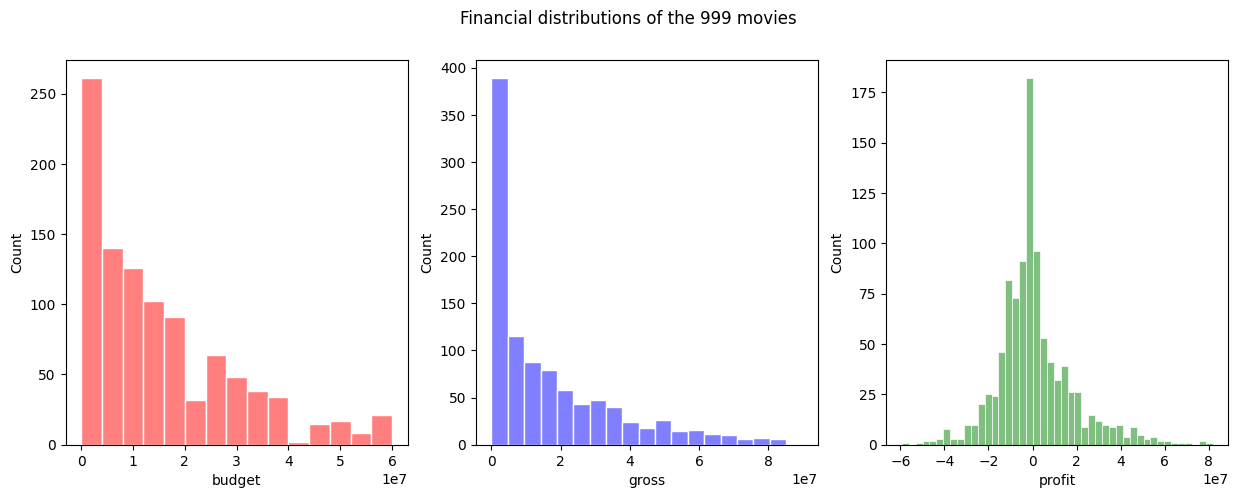

In [20]:
# Initialize the class and prepare the data
steve = MDO_Statistician.from_enriched(
    pre="../data/pre_release.csv", after="../data/after_release.csv",
    path="../data/enriched_data.csv", drop_na=True)
steve.get_dist_financials(plot=True)
steve.show_me_the_world()

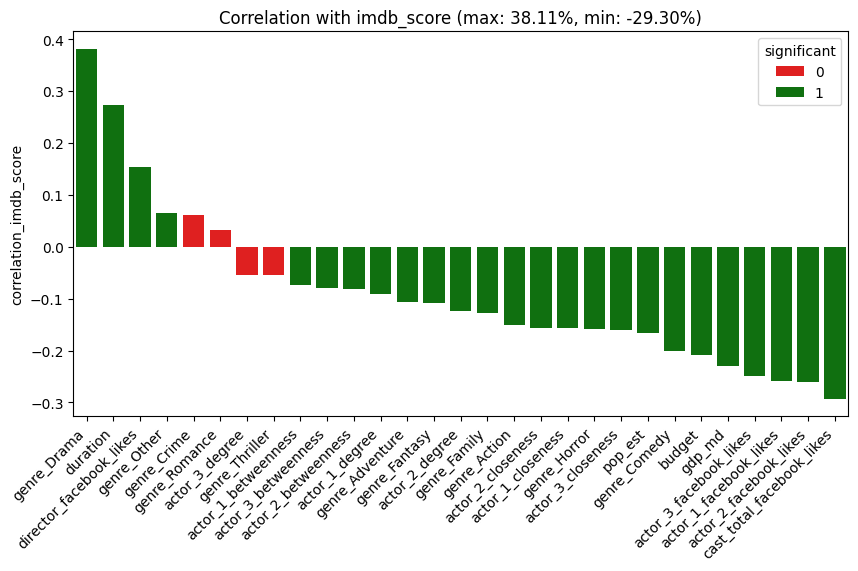

,correlation_imdb_score,p-value,significant
genre_Drama,0.381146,6.840874e-36,1
cast_total_facebook_likes,-0.293039,3.111785e-21,1
duration,0.272442,1.840773e-18,1
actor_2_facebook_likes,-0.261063,4.989041e-17,1
actor_1_facebook_likes,-0.258582,1.003317e-16,1
actor_3_facebook_likes,-0.249528,1.205636e-15,1
gdp_md,-0.229854,1.915215e-13,1
budget,-0.209112,2.471211e-11,1
genre_Comedy,-0.201376,1.337797e-10,1
pop_est,-0.165292,1.488235e-07,1


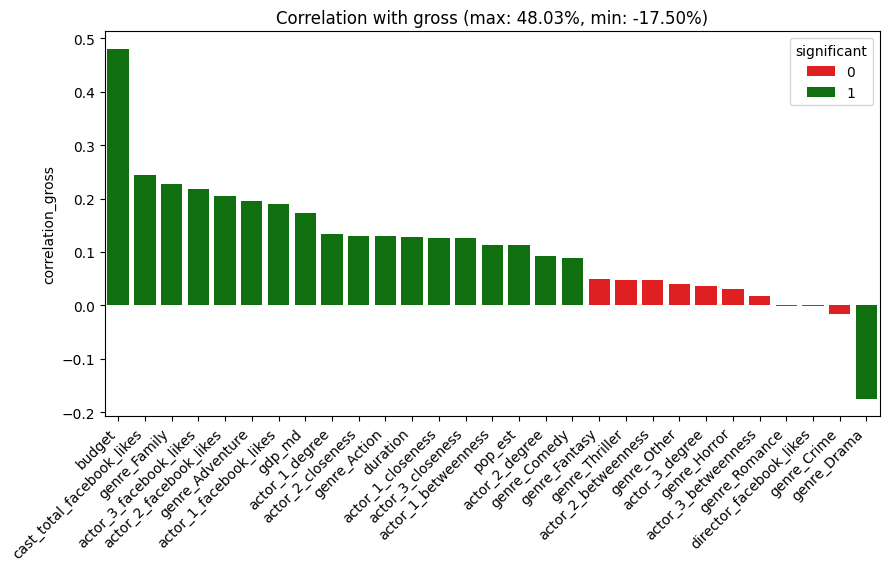

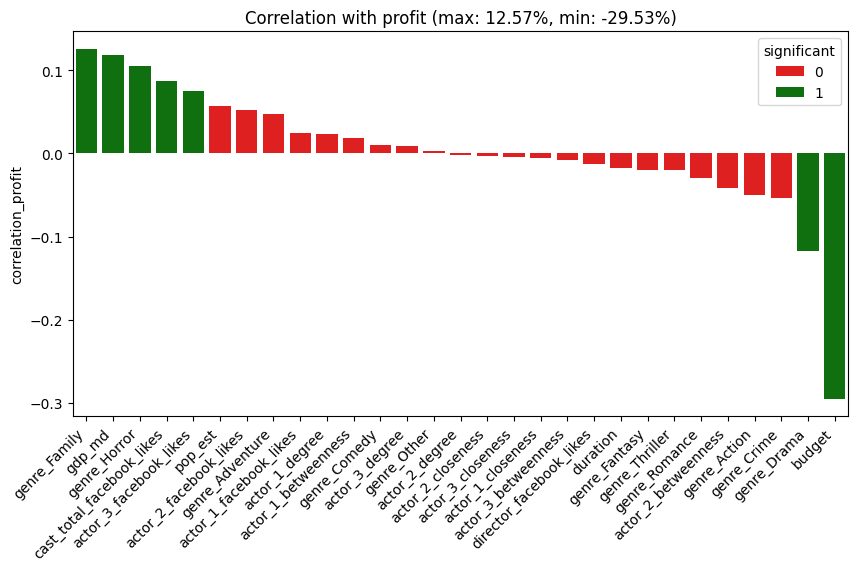

                F-stat imdb_score       p-value
genres                   2.504564  4.435042e-24
content_rating           9.405894  4.871520e-15
director_name            2.293310  6.694339e-12
country                  3.541766  2.669748e-10
language                 4.115983  1.985903e-09
actor_1_name             1.570867  1.407970e-05
actor_2_name             1.184279  1.206892e-01
actor_3_name             1.153045  2.059903e-01
                F-stat gross       p-value
content_rating     12.017801  8.840350e-20
genres              1.648849  2.907194e-08
country             1.704167  9.129680e-03
language            1.679195  2.840095e-02
actor_2_name        1.278302  4.460414e-02
director_name       1.214245  4.694655e-02
actor_1_name        0.984598  5.665695e-01
actor_3_name        0.936283  6.759451e-01
                F-stat profit       p-value
genres               1.747442  6.617980e-10
content_rating       4.970669  4.638081e-07
country              1.532305  3.047912e-02
langu

In [21]:
# Are the financial and public success of a movie comming from the same factors?
display(steve.get_correlation("imdb_score", plot=True))
_ = steve.get_correlation("gross", plot=True)
_ = steve.get_correlation("profit", plot=True)

print(steve.get_anova("imdb_score"))
print(steve.get_anova("gross"))
print(steve.get_anova("profit"))

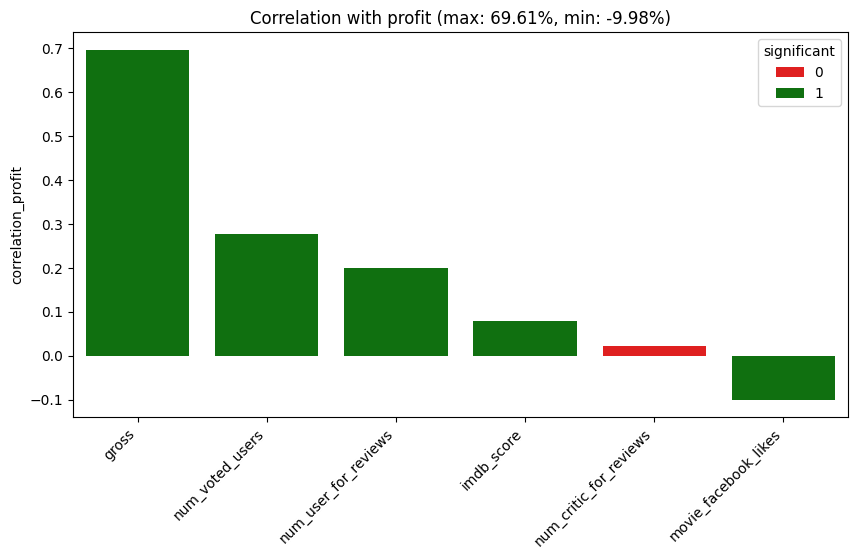

C:\Users\User\AppData\Local\Temp\ipykernel_14624\1848477670.py:93: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.barplot(x=corr.index, y=corr[f"correlation_{target}"], hue=corr["significant"], palette=["r", "g"])


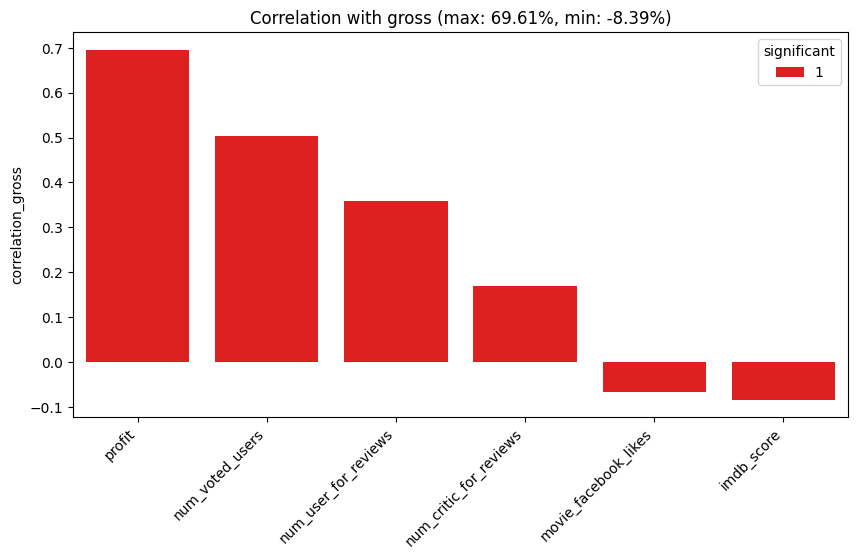

In [22]:
# Are the metrics of success correlated?
_ = steve.get_correlation(
    predictors=[col for col in steve.success_columns if col != "profit"],
    target="profit", plot=True)
_ = steve.get_correlation(
    predictors=[col for col in steve.success_columns if col != "gross"],
    target="gross", plot=True)

## The Agent

In [23]:
class MDO_Agent(MDO_Researcher):
    """Second employee of the Movie Director Office, the agent knows his way around the movie industry.
    He can provide insights into directors, actors and their relationships.

    Base Class
    ----------
    MDO_Researcher : MDO_Researcher
        Support the agent with the data preparation and enrichment.

    Special Attributes
    ------------------
    network : nx.Graph
        Network of actors

    Special Methods
    ---------------

    get_top_directors(top:int=5, sort_by:str="gross") -> pd.DataFrame
        Get the top directors based on a given criteria and display their information.

    get_info_celebrity(name:str, verbose:bool=True) -> dict
        Fetch information about a celebrity (director or actor) from a trusted colleague.

    create_actors_network(
        save_to:str="../data/actors.pickle",
        load_from:str=None, plot:bool=False) -> nx.Graph
        Create a network of actors based on the movies they played in.
    
    show_nth_cluster(n:int=1) -> None
        Show the nth component of the actors network.
    
    show_n_neighbors(actor:str, degree:int=1, plot:bool=False) -> List[str]
        Show the neighbors of an actor in the network up to n connections.

    """

    def __init__(self, **class_arg):
        super().__init__(**class_arg)
        self.network = None

    #># Method 1:

    def get_top_directors(self, top:int=5, sort_by:str="gross") -> pd.DataFrame:
        """Get the top directors based on a given criteria.

        Parameters
        ----------
        top : int, optional
            Number of directors to display, by default 5
        criteria : str, optional
            Criteria to sort the directors, by default "gross"
            Choose from "budget", "gross", "profit", "imdb_score" or "director_facebook_likes"

        Returns
        -------
        pd.DataFrame
            DataFrame with the top directors
        """

        # Define the information to gather for the directors
        criteria = ["budget", "gross", "profit", "imdb_score", "director_facebook_likes"]
        infos = ["director_name","movie_title", "language", "country"]
        genres = [col for col in self.full.columns if "genre_" in col]

        # Group by director and aggregate the information
        top_directors = self.full[criteria+infos+genres].groupby("director_name").agg({
            **{col:"mean" for col in criteria},
            "movie_title":"count", "language":pd.Series.mode, "country":pd.Series.mode,
            **{col:"sum" for col in genres}
        }).sort_values(by=sort_by, ascending=False).head(top)
        top_directors.columns = [
            "Average budget", "Average gross", "Average profit", "Average imdb score", "Average director facebook likes",
            "Number of movies", "Most common language", "Most common country", *genres
        ]

        # Return the top directors
        return top_directors
    
    #># Method 2:

    def get_info_celebrity(self, name:str, verbose:bool=True) -> dict:
        """Get information about a celebrity.

        Parameters
        ----------
        name : str
            Name of the celebrity (director or actor)
        verbose : bool, optional
            Display the information, by default True

        Returns
        -------
        dict
            Information about the celebrity
        """

        # Create the API URL
        api_url = 'https://api.api-ninjas.com/v1/celebrity?name={}'.format(name)

        # Use environment variable to keep the API KEY private when shared
        response = requests.get(api_url, headers={'X-Api-Key': os.environ.get("NINJA_API_KEY", None)})
        
        # Catch eventual failed requests
        if response.status_code == requests.codes.ok:
            details = (response.json()[0])
            if verbose:
                print(f"Here is all I know about {name}:")
                for key, value in details.items():
                    print(f"  - {key}: {value}")
            return details
        else:
            print(f"I'm sorry, I don't know much about {name}.")
            return {}

    #># Method 3:

    def create_actors_network(
            self,
            save_to:str= "../data/actors.pickle",
            load_from:str = None,
            plot:bool=False) -> nx.Graph:        
        """Create a network of actors based on the movies they played in.

        Parameters
        ----------
        save_to : str, optional
            Path to save the network, by default "../data/actors.pickle"
        load_from : str, optional
            Path to load the network from, by default None
        plot : bool, optional
            Plot the network, by default False

        Returns
        -------
        nx.Graph
            Network of actors
        """

        if save_to is not None and load_from is None:
            # Reformat existing data to have the movie-actor pairs
            actor1 = self.full[["movie_title", "actor_1_name"]].rename(columns={"actor_1_name": "actor"})
            actor2 = self.full[["movie_title", "actor_2_name"]].rename(columns={"actor_2_name": "actor"})
            actor3 = self.full[["movie_title", "actor_3_name"]].rename(columns={"actor_3_name": "actor"})
            actors = pd.concat([actor1, actor2, actor3], ignore_index=True)
            actors["movie_title"] = actors["movie_title"].apply(lambda x: x.strip())

            # Group the movies by actors
            graph_data = actors.groupby("actor")["movie_title"].apply(list).reset_index()

            # Create the network
            self.network = nx.Graph()

            # For each actor, add edges with other actors they played with
            for i, (actor, movies) in graph_data.iterrows():
                self.network.add_node(actor)
                print(f"Network creation: {(i+1)/len(graph_data):.2%}", end="\r")
                for _, (actor2, movies2) in graph_data.iloc[i+1:].iterrows():
                    common_movies = set(movies).intersection(set(movies2))
                    if len(common_movies) > 0:
                        self.network.add_edge(actor, actor2, weight=len(common_movies))
            
            # Save the network
            pickle.dump(self.network, open(save_to, "wb"))
        
        elif save_to is None and load_from is not None:
            self.network = pickle.load(open(load_from, "rb"))

        else:
            raise ValueError("You need to choose either to save or to load the network")
        
        # Plot the network
        if plot:
            nx.draw(self.network, with_labels=False, node_size=2)
            plt.show()
    
        return self.network
    
    #># Method 4:

    def show_nth_cluster(self, n:int=1) -> None:
        """Show the nth component of the actors network.

        Parameters
        ----------
        n : int, optional
            Number of the component to display from largest, by default 1

        Returns
        -------
        None
            Display the network component
        """

        # Get the components and order them by size
        components = sorted(nx.connected_components(self.network), key=len, reverse=True)
        chosen_component = list(components[n-1])

        # Plot the chosen component
        subgraph = self.network.subgraph(chosen_component)
        nx.draw(subgraph, with_labels=True, node_size=10, font_size=10, edge_color="lightgrey")
        plt.title(f"Component {n} of the actors network ({len(chosen_component)} actors)")
        plt.show()
    
    #># Method 5:

    def show_n_neighbors(self, actor:str, degree:int=1, plot:bool=False) -> None:
        """Show the neighbors of an actor in the network up to n connections.

        Parameters
        ----------
        actor : str
            Name of the actor
        degree : int, optional
            Number of neighbors to display, by default 1
        plot : bool, optional
            Plot the network, by default False

        Returns
        -------
        List[str]
            List of the neighbors
        
        Raises
        ------
        KeyError
            If the actor is not found in the network
        """

        # Get the neighbors of the actor
        sub_nodes = [actor]
        try:
            sub_nodes = list(nx.single_source_shortest_path(self.network, actor, cutoff=degree).keys())
        except KeyError:
            raise KeyError(f"{actor} is not in the network")
        
        # Show the subgraph of the neighbors
        if plot:
            subgraph = self.network.subgraph(sub_nodes)
            color_map = ["lightgreen" if node == actor else "lightblue" for node in subgraph.nodes()]
            size_map = [100 if node == actor else 10 for node in subgraph.nodes()]
            nx.draw(
                subgraph, with_labels=True, node_size=size_map, node_color=color_map,
                font_size=10, edge_color="lightgrey")
            plt.title(f"Neighbors of {actor} up to degree {degree} (n={len(sub_nodes) - 1})")
            plt.show()
        
        sub_nodes.remove(actor)
        sub_nodes.sort()
        return sub_nodes


### Agent Demo

In [24]:
josh = MDO_Agent.from_enriched(
    pre="../data/pre_release.csv",
    after="../data/after_release.csv",
    path="../data/enriched_data.csv")

print("Who directed the most movies?")
display(josh.get_top_directors(3, "movie_title"))
print("Who made the most action movies?")
display(josh.get_top_directors(3, "genre_Action"))

Who directed the most movies?


,Average budget,Average gross,Average profit,Average imdb score,Average director facebook likes,Number of movies,Most common language,Most common country,genre_Drama,genre_Comedy,genre_Romance,genre_Thriller,genre_Crime,genre_Action,genre_Adventure,genre_Horror,genre_Family,genre_Fantasy,genre_Other
director_name,,,,,,,,,,,,,,,,,,,
Spike Lee,6.867857e+06,1.233011e+07,5.462248e+06,6.300,0.0,7,English,USA,5,6,1,0,0,0,0,0,0,0,4
Wes Craven,2.200000e+07,1.798064e+07,-4.019357e+06,5.175,0.0,4,English,USA,0,2,1,2,0,0,0,4,0,2,2
Brian Levant,4.575000e+07,5.030613e+07,4.556132e+06,4.875,32.0,4,English,USA,0,4,1,0,0,1,1,0,4,0,2


Who made the most action movies?


,Average budget,Average gross,Average profit,Average imdb score,Average director facebook likes,Number of movies,Most common language,Most common country,genre_Drama,genre_Comedy,genre_Romance,genre_Thriller,genre_Crime,genre_Action,genre_Adventure,genre_Horror,genre_Family,genre_Fantasy,genre_Other
director_name,,,,,,,,,,,,,,,,,,,
John Glen,2.987500e+07,5.101323e+07,21138228.0,6.550000,46.0,4,English,UK,0,0,0,4,0,4,4,0,0,0,0
Les Mayfield,2.933333e+07,9.898363e+06,-19434970.0,5.333333,10.0,3,English,USA,0,2,0,0,2,3,0,0,0,0,1
Lewis Gilbert,1.916667e+07,5.086667e+07,31700000.0,6.766667,43.0,3,English,UK,0,0,0,3,0,3,3,0,0,0,2


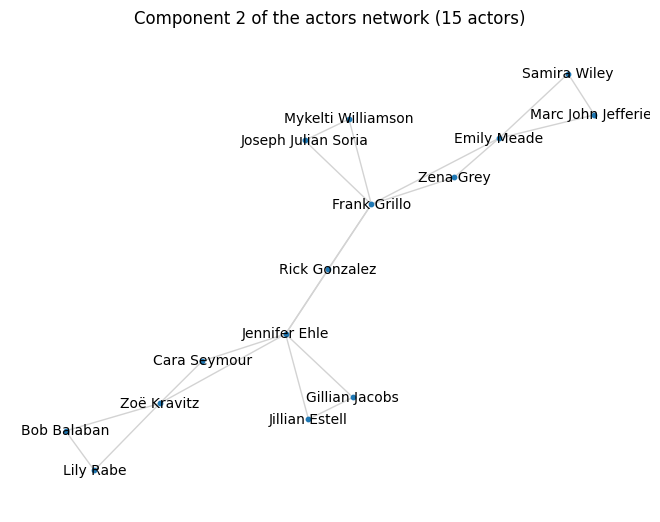

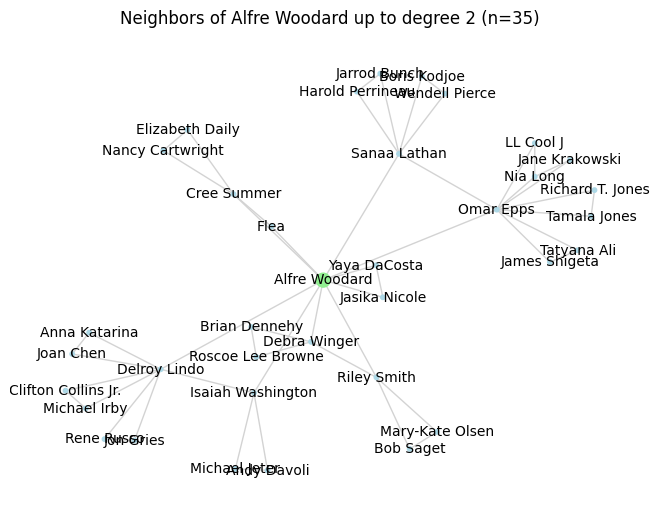

['Andy Davoli',
 'Anna Katarina',
 'Bob Saget',
 'Boris Kodjoe',
 'Brian Dennehy',
 'Clifton Collins Jr.',
 'Cree Summer',
 'Debra Winger',
 'Delroy Lindo',
 'Elizabeth Daily',
 'Flea',
 'Harold Perrineau',
 'Isaiah Washington',
 'James Shigeta',
 'Jane Krakowski',
 'Jarrod Bunch',
 'Jasika Nicole',
 'Joan Chen',
 'Jon Gries',
 'LL Cool J',
 'Mary-Kate Olsen',
 'Michael Irby',
 'Michael Jeter',
 'Nancy Cartwright',
 'Nia Long',
 'Omar Epps',
 'Rene Russo',
 'Richard T. Jones',
 'Riley Smith',
 'Roscoe Lee Browne',
 'Sanaa Lathan',
 'Tamala Jones',
 'Tatyana Ali',
 'Wendell Pierce',
 'Yaya DaCosta']

In [25]:
# josh.create_actors_network(save_to="../data/actors.pickle", plot=True)

most_connected_actor = josh.full.iloc[josh.full["actor_1_degree"].idxmax()]["actor_1_name"]
josh.create_actors_network(load_from="../data/actors.pickle", save_to=None, plot=False)
josh.show_nth_cluster(2)
josh.show_n_neighbors(most_connected_actor, degree=2, plot=True)

In [26]:
josh.get_info_celebrity("Bruce Willis")
# josh.get_info_cebrity("Quentin Tarantino")

Here is all I know about Bruce Willis:
  - name: bruce willis
  - net_worth: 250000000
  - gender: male
  - nationality: us
  - occupation: ['actor', 'film_producer', 'television_producer', 'businessperson', 'voice_actor', 'singer', 'musician', 'writer', 'composer']
  - height: 1.83
  - birthday: 1955-03-19
  - age: 69
  - is_alive: True


{'name': 'bruce willis',
 'net_worth': 250000000,
 'gender': 'male',
 'nationality': 'us',
 'occupation': ['actor',
  'film_producer',
  'television_producer',
  'businessperson',
  'voice_actor',
  'singer',
  'musician',
  'writer',
  'composer'],
 'height': 1.83,
 'birthday': '1955-03-19',
 'age': 69,
 'is_alive': True}

## The Forecaster

In [27]:
class MDO_Forecaster(MDO_Researcher):
    """Last employee of the Movie Director Office, the forecaster is in charge of predicting the success of
    a movie before it is released. He can build models and evaluate their performance.

    Base Class
    ----------
    MDO_Researcher : MDO_Researcher
        Support the forecaster with the data preparation and enrichment.
    
    Special Methods
    ---------------

    """

    def __init__(self, pre: str = "../data/pre_release.csv", after: str = "../data/after_release.csv") -> None:
        super().__init__(pre, after)
        self.models = {}
        self.X = None
        self.y = None
        self.logs = None

    #># Method 1:

    def prepare_X_y(
            self,
            exclude:list = [
                "movie_title", "director_name", "actor_1_name", "actor_2_name", "actor_3_name", "genres"
            ],
            subset:list=[],
            target:str="gross",
            verbose:bool=True) -> None:
        """Prepare the predictors for the model.

        Parameters
        ----------
        exclude : list, optional
            Columns to exclude from the predictors, by default [
                "movie_title", "director_name", "actor_1_name", "actor_2_name", "actor_3_name", "genres"
            ]
        subset : list, optional
            Subset of the columns to keep, by default []
        target : str, optional
            Target variable for the model, by default "gross"
        verbose : bool, optional
            Display execution details, by default True
        """

        # Define the predictors and the target
        self.y = self.full[target]

        # Keep only the predictors
        self.X = self.full[self.pred_columns].drop(columns=exclude)

        if subset != []:
            self.X = self.X[subset]

        if verbose:
            print(f"{self.X.shape[1]} initial predictors")

        # Dummy encode the categorical variables
        self.X = pd.get_dummies(self.X, drop_first=True)
        if verbose:
            print(f"{self.X.shape[1]} predictors after encoding")

        # Filter out missing values
        if verbose:
            print(f"{self.X.shape[0]} rows before filtering missing values")
        self.X.dropna(inplace=True)
        self.y = self.y[self.X.index]
        if verbose:
            print(f"{self.X.shape[0]} rows after filtering missing values")
    
    #># Method 2:

    def initiate_models(self, models:list=[
        "DummyRegressor", "LinearRegression", "Lasso", "SVR", "KNeighborsRegressor",
        "RandomForestRegressor", "XGBRegressor", "MLPRegressor"],
        standard_scaling:bool=True) -> None:
        """Initiate the models to be used for prediction.

        Parameters
        ----------
        models : list, optional
            List of models to initiate, by default [
                "DummyRegressor", "LinearRegression", "Lasso", "SVR", "KNeighborsRegressor",
                "RandomForestRegressor", "XGBRegressor", "MLPRegressor"
            ]
        standard_scaling : bool, optional
            Standardize the predictors, by default True
        
        Returns
        -------
        dict
            Dictionary of initiated models
        """

        # Initiate the models
        if "DummyRegressor" in models:
            self.models["DummyRegressor"] = make_pipeline(
                StandardScaler() if standard_scaling else None, DummyRegressor())
        if "LinearRegression" in models:
            self.models["LinearRegression"] = make_pipeline(
                StandardScaler() if standard_scaling else None, LinearRegression())
        if "Lasso" in models:
            self.models["Lasso"] = make_pipeline(
                StandardScaler() if standard_scaling else None, Lasso())
        if "KNeighborsRegressor" in models:
            self.models["KNeighborsRegressor"] = make_pipeline(
                StandardScaler() if standard_scaling else None, KNeighborsRegressor())
        if "SVR" in models:
            self.models["SVR"] = make_pipeline(
                StandardScaler() if standard_scaling else None, SVR(kernel="rbf"))
        if "RandomForestRegressor" in models:
            self.models["RandomForestRegressor"] = make_pipeline(
                StandardScaler() if standard_scaling else None, RandomForestRegressor())
        if "XGBRegressor" in models:
            self.models["XGBRegressor"] = make_pipeline(
                StandardScaler() if standard_scaling else None, XGBRegressor())
        if "MLPRegressor" in models:
            self.models["MLPRegressor"] = make_pipeline(
                StandardScaler() if standard_scaling else None, MLPRegressor())
            
        return self.models
    
    #># Method 3:

    def evaluate_standard_models(
            self, cv:int=5, logs:str="logs.csv", rank:str="mse",
            prefix:str="", verbose:bool=True) -> None:
        """Evaluate the performance of the standard models.

        Parameters
        ----------
        cv : int, optional
            Number of cross-validation folds, by default 5
        logs : str, optional
            Path to save the logs, by default "logs.csv"
        rank : str, optional
            Metric to rank the models, by default "mse"
        prefix : str, optional
            Prefix to add to the model names, by default ""
        verbose : bool, optional
            Display the evaluation results, by default True

        Returns
        -------
        pd.DataFrame
            Logs of the model evaluation
        """

        # Check if the logs csv exists and create pandas table if not
        if not os.path.exists(logs):
            self.logs = pd.DataFrame(columns=["model", "mse", "mape", "r2", "timestamp"])
            self.logs.to_csv(logs, index=False)
        
        # Read the logs file into the dataframe
        self.logs = pd.read_csv(logs)

        # Set up the scorer
        scoring = {
            "neg_mse": "neg_mean_squared_error",
            "neg_mape": "neg_mean_absolute_percentage_error",
            "r2": "r2"
        }
        
        for model_name, model in self.models.items():
            if verbose:
                print(f"Evaluating {model_name}")

            scores = cross_validate(
                model, self.X, self.y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
            
            # Add the results to the logs
            if prefix+model_name not in self.logs["model"].values:
                self.logs.loc[len(self.logs)] = {
                    "model": prefix+model_name,
                    "mse": -scores["test_neg_mse"].mean(),
                    "mape": -scores["test_neg_mape"].mean(),
                    "r2": scores["test_r2"].mean(),
                    "timestamp": datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
                }
                self.logs.sort_values(by=rank, inplace=True)

                # Save the logs
                self.logs.to_csv(logs, index=False)

        return self.logs

    #># Method 4:

    def evaluate_single_model(
            self, estimator, cv:int=5, logs:str="logs.csv", rank:str="mse",
            name_log:str="", verbose:bool=True) -> None:
        """Evaluate the performance of a chosen estimator.

        Parameters
        ----------
        estimator : model
            Model to evaluate
        cv : int, optional
            Number of cross-validation folds, by default 5
        logs : str, optional
            Path to save the logs, by default "logs.csv"
        rank : str, optional
            Metric to rank the models, by default "mse"
        name_log : str, optional
            Name to register the model in the logs, by default ""
        verbose : bool, optional
            Display the evaluation results, by default True

        Returns
        -------
        pd.DataFrame
            Logs of the model evaluation
        """

        # Check if the logs csv exists and create pandas table if not
        if not os.path.exists(logs):
            self.logs = pd.DataFrame(columns=["model", "mse", "mape", "r2", "timestamp"])
            self.logs.to_csv(logs, index=False)
        
        # Read the logs file into the dataframe
        self.logs = pd.read_csv(logs)

        # Set up the scorer
        scoring = {
            "neg_mse": "neg_mean_squared_error",
            "neg_mape": "neg_mean_absolute_percentage_error",
            "r2": "r2"
        }
    
        scores = cross_validate(
            estimator, self.X, self.y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
        
        # Add the results to the logs
        if name_log not in self.logs["model"].values:
            self.logs.loc[len(self.logs)] = {
                "model": name_log,
                "mse": -scores["test_neg_mse"].mean(),
                "mape": -scores["test_neg_mape"].mean(),
                "r2": scores["test_r2"].mean(),
                "timestamp": datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
            }
            self.logs.sort_values(by=rank, inplace=True)

            # Save the logs
            self.logs.to_csv(logs, index=False)
        
        return self.logs

## Forecaster Demo

In [39]:
tom = MDO_Forecaster.from_enriched(
    pre="../data/pre_release.csv",
    after="../data/after_release.csv",
    path="../data/enriched_data.csv",
    drop_na=False)

steve = MDO_Statistician.from_enriched(
    pre="../data/pre_release.csv",
    after="../data/after_release.csv",
    path="../data/enriched_data.csv",
    drop_na=True)

gross_corr = steve.get_correlation("gross", plot=False)
gross_corr = gross_corr[gross_corr["significant"] == 1].index.tolist()

tom.prepare_X_y(target="gross", subset=["gdp_md"], verbose=True)
tom.evaluate_single_model(
    LinearRegression(), cv=5, logs="simple_model_logs.csv", rank="mse", name_log="LR gdp_md")



1 initial predictors
1 predictors after encoding
1046 rows before filtering missing values
1039 rows after filtering missing values


,model,mse,mape,r2,timestamp
0,LR significant features,2.695341e+14,111.266586,-0.244837,2024-04-23 09:00
1,LR budget + cast_fb_likes,2.755604e+14,119.575458,-0.206964,2024-04-23 08:56
2,LR all features,2.821058e+14,114.318023,-0.556587,2024-04-23 08:57
3,LR_budget,2.883176e+14,151.776651,-0.367388,2024-04-23 08:54
4,RF significant features,3.268791e+14,211.188326,-1.413601,2024-04-24 09:32
5,RF all features,3.312395e+14,226.117642,-1.741651,2024-04-24 09:32
6,LR_cast_fb_likes,3.803406e+14,220.990182,-1.359902,2024-04-23 08:56
7,KN significant features,3.818521e+14,117.367751,-0.992415,2024-04-24 09:35
8,KN budget and fb likes,3.834477e+14,138.957906,-0.726172,2024-04-24 09:34
9,KN all features,3.838388e+14,117.374464,-0.998252,2024-04-24 09:35


In [30]:
tom.full.columns

Index(['director_name', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_2_name', 'actor_1_facebook_likes',
       'genres', 'actor_1_name', 'movie_title', 'cast_total_facebook_likes',
       'actor_3_name', 'language', 'country', 'content_rating', 'budget',
       'actor_2_facebook_likes', 'num_critic_for_reviews', 'gross',
       'num_voted_users', 'num_user_for_reviews', 'imdb_score',
       'movie_facebook_likes', 'genre_Drama', 'genre_Comedy', 'genre_Romance',
       'genre_Thriller', 'genre_Crime', 'genre_Action', 'genre_Adventure',
       'genre_Horror', 'genre_Family', 'genre_Fantasy', 'genre_Other',
       'profit', 'pop_est', 'gdp_md', 'actor_1_degree', 'actor_1_closeness',
       'actor_1_betweenness', 'actor_2_degree', 'actor_2_closeness',
       'actor_2_betweenness', 'actor_3_degree', 'actor_3_closeness',
       'actor_3_betweenness'],
      dtype='object')

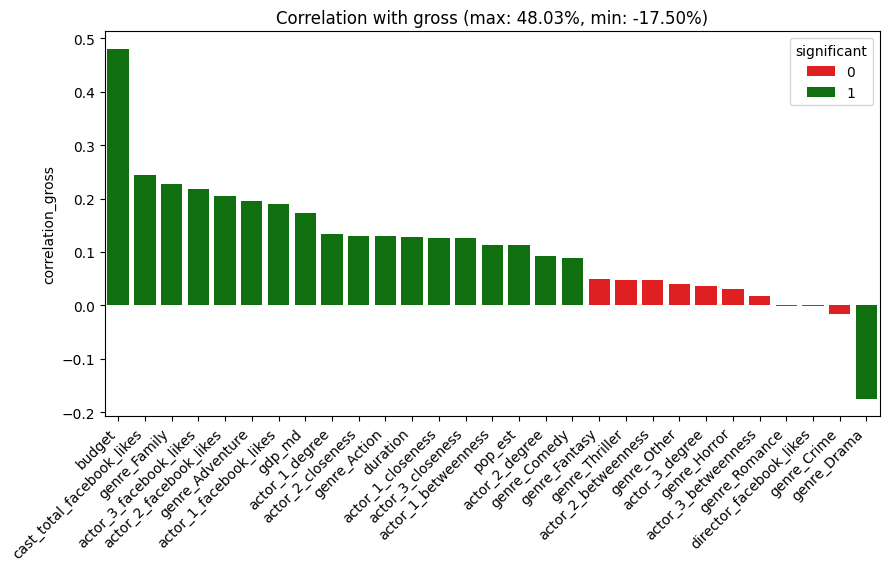

19 initial predictors
19 predictors after encoding
1046 rows before filtering missing values
1034 rows after filtering missing values
Evaluating DummyRegressor
Evaluating LinearRegression
Evaluating Lasso
Evaluating KNeighborsRegressor
Evaluating SVR
Evaluating RandomForestRegressor
Evaluating XGBRegressor
Evaluating MLPRegressor


,model,mse,mape,r2,timestamp
0,enriched_sign_scaled_LinearRegression,2.695341e+14,1.112666e+02,-2.448366e-01,2024-04-23 09:03
1,enriched_sign_scaled_Lasso,2.695341e+14,1.112668e+02,-2.448370e-01,2024-04-23 09:03
2,Lasso,2.752081e+14,1.090124e+02,-3.832356e-01,2024-04-23 09:02
3,scaled_Lasso,2.752938e+14,1.090550e+02,-3.852675e-01,2024-04-23 09:03
4,LinearRegression,2.753864e+14,1.066740e+02,-3.943686e-01,2024-04-23 09:02
5,enriched_Lasso,2.809854e+14,1.140435e+02,-5.144568e-01,2024-04-23 09:03
6,enriched_scaled_Lasso,2.810412e+14,1.140543e+02,-5.157991e-01,2024-04-23 09:03
7,enriched_LinearRegression,2.821058e+14,1.143180e+02,-5.565870e-01,2024-04-23 09:03
8,enriched_MLPRegressor,2.961877e+14,1.032273e+02,-2.783284e-01,2024-04-23 09:03
9,RandomForestRegressor,3.033631e+14,1.748263e+02,-8.851631e-01,2024-04-23 09:02


In [15]:
# Specify what you want Tom to predict and how (features and scaling)
target = "gross"
only_significant = True
enriched = True
standard_scaling = True

pref = f"{"enriched_" if enriched else ""}{'sign_' if only_significant else ""}{'scaled_' if standard_scaling else ""}"

# Create Tom and Steve from the enriched dataset
if enriched:
    tom = MDO_Forecaster.from_enriched(
        pre="../data/pre_release.csv",
        after="../data/after_release.csv",
        path="../data/enriched_data.csv",
        drop_na=False)
    steve = MDO_Statistician.from_enriched(
        pre="../data/pre_release.csv",
        after="../data/after_release.csv",
        path="../data/enriched_data.csv",
        drop_na=True)

# Create Tom and Steve from the original dataset
else:
    tom = MDO_Forecaster.from_directory("../data", drop_na=False)
    tom.split_genres(top=10)
    tom.enrich_all(
        save=False, country=False, actors=False)
    steve = MDO_Statistician.from_directory("../data", drop_na=True)
    steve.split_genres(top=10)
    steve.enrich_all(
        save=False, country=False, actors=False)

# Ask Steve for the significant predictors
if only_significant:
    corr_target = steve.get_correlation(target, plot=True)["significant"]
    significant_predictors = corr_target[corr_target == 1].index.tolist()

# Or use all the predictors
else:
    significant_predictors = []

# Ask Tom to evaluate all the models
tom.prepare_X_y(subset=significant_predictors, target=target)
tom.initiate_models(standard_scaling=standard_scaling)
display(tom.evaluate_standard_models(cv=5, logs=f"{target}_logs.csv", rank="mse", prefix=pref))